## Designing a value function accounting for feature independence that is undealt with by SHAP explanation (Unfinished)

In [1]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss, accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler

df = pd.read_csv("../preprocessed/clean_survey.csv", index_col=False)
# split to indenpendent and dependent variables
# drop all variables computing the labels
X = df.drop(['q_031_adjusted', 'invol_score', 'q_031', 'involvement_level'] + [f'q_0{i}' for i in range(45, 55)], axis=1)
y = df["involvement_level"]

# Encode the class labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the dataset into training and test sets
X_train, X_test, y_encoded_train, y_encoded_test = train_test_split(X, y_encoded, random_state=42)

# Data Preprocessing
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Store in dataframe for plotting
feature_names = X_train.columns.tolist()
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_names)

label_mapping = {index: label for index, label in enumerate(label_encoder.classes_)}
print(label_mapping)

{0: 'High', 1: 'Low', 2: 'Medium'}


In [2]:
import pickle
# fit the best model
# Load the model from a file
with open('../models/neural_1.pkl', 'rb') as file:
    model1 = pickle.load(file)

model1.fit(X_train_scaled, y_encoded_train)
# Making predictions
y_pred1 = model1.predict(X_test_scaled)

accuracy1 = accuracy_score(y_encoded_test, y_pred1)
print("Testing Subset Accuracy: ", accuracy1)
print("Hamming Loss:", hamming_loss(y_encoded_test, y_pred1))

# Micro-average
print("F1 Score (Micro):", f1_score(y_encoded_test, y_pred1, average='micro'))
# Macro-average
print("F1 Score (Macro):", f1_score(y_encoded_test, y_pred1, average='macro'))
# Weighted-average
print("F1 Score (Weighted):", f1_score(y_encoded_test, y_pred1, average='weighted'))

# ROC-AUC
# Note: roc_auc_score expects a shape of (n_samples,) for binary problems and
# (n_samples, n_classes) for multi-class/multi-label with one-hot encoding.
# ROC-AUC calculation needs probabilistic predictions `y_proba`
# use macro since class labels are imbalanced
y_proba = model1.predict_proba(X_test_scaled)
roc_auc = roc_auc_score(y_encoded_test, y_proba, average='macro', multi_class='ovr')
print("ROC-AUC (Macro):", roc_auc)



Testing Subset Accuracy:  0.6438356164383562
Hamming Loss: 0.3561643835616438
F1 Score (Micro): 0.6438356164383562
F1 Score (Macro): 0.6121799081551403
F1 Score (Weighted): 0.6433986783111004
ROC-AUC (Macro): 0.8132172353492225


In [3]:
import numpy as np
def custom_value_function(model, baseline_data, feature_indices, interaction_indices):
    """
    Compute the value of the model prediction with and without the interaction terms.
    
    Parameters:
    - model: Trained machine learning model.
    - baseline_data: Data used as the baseline (background) dataset.
    - feature_indices: Indices of the primary features to evaluate.
    - interaction_indices: Indices of the features to interact with the primary features.
    
    Returns:
    - Value difference caused by the interaction.
    """

    
    # Create a copy of the baseline data to manipulate
    data_with_interaction = baseline_data.copy()
    data_without_interaction = baseline_data.copy()
    
    # Set interaction features to their mean or a neutral value in data_without_interaction
    for idx in interaction_indices:
        data_without_interaction.iloc[:, idx] = baseline_data.iloc[:, idx].mean()
    
    # Predict with and without interaction
    prediction_with_interaction = model.predict_proba(data_with_interaction.values)[:, 1]
    prediction_without_interaction = model.predict_proba(data_without_interaction.values)[:, 1]
    
    # Calculate the difference due to interaction
    value_difference = np.mean(prediction_with_interaction - prediction_without_interaction)
    
    return value_difference

In [4]:
import shap
import itertools
def compute_interaction_effects(model, X, feature_names):
    # Initialize SHAP explainer on the model
    explainer = shap.KernelExplainer(model.predict_proba, X)

    # Dictionary to store interaction effects
    interaction_effects = {}

    # Calculate interactions between all pairs of features
    for feat_a, feat_b in itertools.combinations(feature_names, 2):
        idx_a = X.columns.get_loc(feat_a)
        idx_b = X.columns.get_loc(feat_b)

        # Calculate the interaction effect
        interaction_value = custom_value_function(model, X, [idx_a], [idx_b])
        interaction_effects[(feat_a, feat_b)] = interaction_value
    
    return interaction_effects

# Example usage
interaction_effects = compute_interaction_effects(model1, X_test_scaled_df, ['q_030', 'q_021', 'q_025'])

Using 219 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


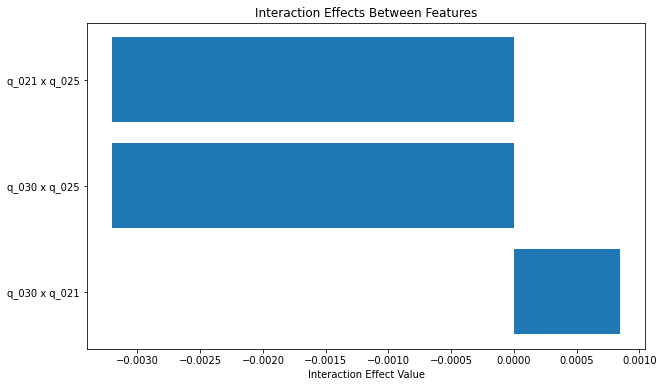

In [5]:
import matplotlib.pyplot as plt

# Plot interaction effects
plt.figure(figsize=(10, 6))
names, values = zip(*interaction_effects.items())
plt.barh(range(len(names)), values, tick_label=[f"{a} x {b}" for a, b in names])
plt.xlabel('Interaction Effect Value')
plt.title('Interaction Effects Between Features')
plt.show()

Before applying SHAP, do a correlation analysis to find highly interacting feature pairs.

In [14]:
# Compute the correlation matrix
corr_matrix = X_train_scaled_df.corr().abs()
corr_matrix

,q_000,q_001,q_003,q_004,q_005,q_006,q_007,q_008,q_009,q_011,...,q_125_none,q_125_other,q_130_ACT,q_130_NSW,q_130_NT,q_130_QLD,q_130_SA,q_130_TAS,q_130_VIC,q_130_WA
q_000,1.000000,0.049903,0.256543,0.167943,0.226024,0.212825,0.189307,0.280651,0.301535,0.209196,...,0.096321,0.008710,0.074067,0.083569,0.025828,0.001563,0.051621,0.047694,0.159945,0.036922
q_001,0.049903,1.000000,0.108317,0.057994,0.021039,0.008038,0.016355,0.015211,0.013852,0.051934,...,0.028142,0.029730,0.001382,0.012564,0.002130,0.012654,0.003613,0.013221,0.013354,0.046457
q_003,0.256543,0.108317,1.000000,0.214660,0.264891,0.161847,0.190428,0.180217,0.280224,0.237975,...,0.105369,0.006056,0.039339,0.065728,0.054312,0.006910,0.091384,0.040850,0.153212,0.055473
q_004,0.167943,0.057994,0.214660,1.000000,0.170764,0.167594,0.122863,0.215559,0.139821,0.122239,...,0.082332,0.036288,0.036437,0.037971,0.044416,0.106358,0.066461,0.079120,0.072732,0.063724
q_005,0.226024,0.021039,0.264891,0.170764,1.000000,0.220608,0.153931,0.175262,0.159404,0.233553,...,0.089531,0.042583,0.019635,0.029016,0.042271,0.064769,0.076097,0.047702,0.092577,0.015221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
q_130_QLD,0.001563,0.012654,0.006910,0.106358,0.064769,0.071818,0.043102,0.039825,0.067799,0.067677,...,0.035946,0.018639,0.062548,0.371575,0.096443,1.000000,0.163595,0.096443,0.269957,0.157226
q_130_SA,0.051621,0.003613,0.091384,0.066461,0.076097,0.060867,0.023131,0.000675,0.016460,0.011996,...,0.020909,0.020909,0.036383,0.216135,0.056098,0.163595,1.000000,0.056098,0.157026,0.091454
q_130_TAS,0.047694,0.013221,0.040850,0.079120,0.047702,0.005150,0.011674,0.029653,0.068186,0.065537,...,0.012326,0.012326,0.021448,0.127416,0.033071,0.096443,0.056098,1.000000,0.092570,0.053914
q_130_VIC,0.159945,0.013354,0.153212,0.072732,0.092577,0.127569,0.124956,0.210926,0.241464,0.138426,...,0.077269,0.034503,0.060037,0.356655,0.092570,0.269957,0.157026,0.092570,1.000000,0.150913


In [9]:
# Select highly correlated features
high_corr_threshold = 0.5  # This threshold can be adjusted
high_corr_var = [(c1, c2) for c1 in corr_matrix.columns for c2 in corr_matrix.columns if c1 < c2 and corr_matrix.at[c1, c2] > high_corr_threshold]
print("Highly correlated variable pairs:", high_corr_var)

Highly correlated variable pairs: [('q_123_regional', 'q_123_urban'), ('q_125_female', 'q_125_male')]
